# Часть3. Предсказание настроения отзыва по тексту

#### [3.1 Предобработка отзывов на детские площадки](#3.1)

#### [3.2 Предобработка отзывов на парки для обучения сети](#3.2)

#### [3.3 Обучение](#3.3)
[Sklearn](#Sk)
[TENSORFLOW](#Tf)

## Импорт и настройка отображения

In [9]:
import matplotlib.pyplot as pltax 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from tensorflow.keras.layers import Dense, GRU, Input, Dropout, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import ModelCheckpoint

import pickle

In [10]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

In [12]:
from tensorflow.keras.optimizers.legacy import Adam

In [13]:
#whitegrid,darkgrid,white,ticks,white
sns.set_theme(style="whitegrid")
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
plt.rcParams["figure.figsize"] = (10,5)
#plt.rcParams["xtick.labelsize"] = 7
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
import plotly.io as pio

In [6]:
#увеличиваю отображение таблиц в ячейках вывода, чтобы показывало все данные
#pd.options.display.max_rows = 30000
#pd.options.display.max_columns = 100

In [14]:
df_playground_reviews= pd.read_csv('playground_reviews.csv')
df_playground_reviews

,name,gender,date,review,comment,location,resource
0,Дмитрий,male,2022,5,"Главное, ребёнку нравится. Но летом народу оче...",Парк Горького. Салют,google
1,Михаил Лось,male,2022,5,Здесь очень весело!),Парк Горького. Салют,google
2,Vika Andreeva,female,2021,5,Очень классное место.Очень весело.Особенно пон...,Парк Горького. Салют,google
3,Светлана Рабинович,female,2021,5,"Замечательный комплекс площадок, много качелей...",Парк Горького. Салют,google
4,Игорь Тухкин,male,2021,5,NaN,Парк Горького. Салют,google
...,...,...,...,...,...,...,...
1946,Рафаэль Т.,male,2020,NaN,Интересная площадка для детей,Бунинские луга. Пирамиды,yandex
1947,Татьяна Б,female,2020,NaN,Очень хорошая площадка! Нам очень нравится. Го...,Бунинские луга. Пирамиды,yandex
1948,Ольга Кузнецова,female,2020,NaN,Мой ребенок готов сюда эмигрировать.,Бунинские луга. Пирамиды,yandex
1949,Иван,male,2020,NaN,Шикарная площадка с водой. Дети часами могут п...,Бунинские луга. Пирамиды,yandex


<a id='3.1'></a>

## 3.1 Предобработка отзывов на детские площадки

### Удалю строки с пустыми комментариями, для того чтобы они не повлияли на предсказания

In [15]:
df_playground_reviews = df_playground_reviews.dropna(subset=['comment']).reset_index(drop=True)
df_playground_reviews

,name,gender,date,review,comment,location,resource
0,Дмитрий,male,2022,5,"Главное, ребёнку нравится. Но летом народу оче...",Парк Горького. Салют,google
1,Михаил Лось,male,2022,5,Здесь очень весело!),Парк Горького. Салют,google
2,Vika Andreeva,female,2021,5,Очень классное место.Очень весело.Особенно пон...,Парк Горького. Салют,google
3,Светлана Рабинович,female,2021,5,"Замечательный комплекс площадок, много качелей...",Парк Горького. Салют,google
4,Денис Пупыкин,male,2021,5,Отличное место для игр с детьми))),Парк Горького. Салют,google
...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,Интересная площадка для детей,Бунинские луга. Пирамиды,yandex
1264,Татьяна Б,female,2020,NaN,Очень хорошая площадка! Нам очень нравится. Го...,Бунинские луга. Пирамиды,yandex
1265,Ольга Кузнецова,female,2020,NaN,Мой ребенок готов сюда эмигрировать.,Бунинские луга. Пирамиды,yandex
1266,Иван,male,2020,NaN,Шикарная площадка с водой. Дети часами могут п...,Бунинские луга. Пирамиды,yandex


In [7]:
df_playground_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      1268 non-null   object
 1   gender    1268 non-null   object
 2   date      1268 non-null   int64 
 3   review    522 non-null    object
 4   comment   1268 non-null   object
 5   location  1268 non-null   object
 6   resource  1268 non-null   object
dtypes: int64(1), object(6)
memory usage: 69.5+ KB


### Узнаю сколько пропущенных значений

In [6]:
df_playground_reviews['review'].isnull().sum()/len(df_playground_reviews)
#df_playground_reviews.isnull().sum()

0.5883280757097792

почти 59% пропущенных оценок в датасете

<AxesSubplot:xlabel='count', ylabel='review'>

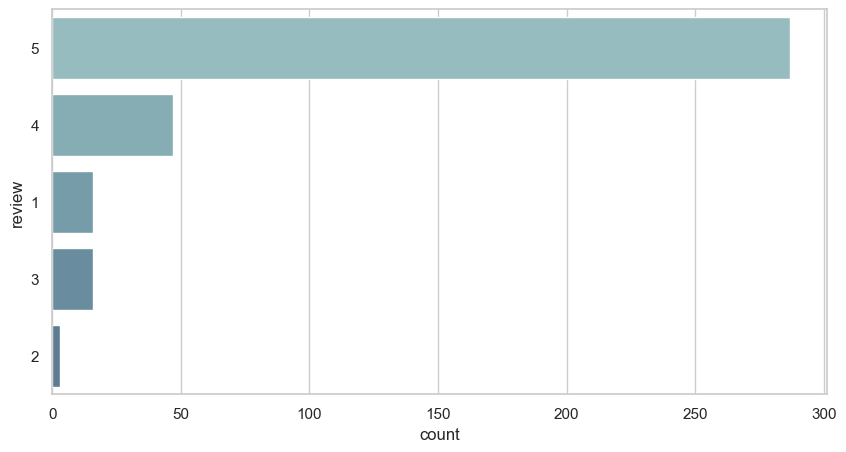

In [10]:
sns.countplot(y = df_playground_reviews[:369].review, palette=pal )

### Длина отзывов

In [16]:
df_playground_reviews['Length'] = df_playground_reviews['comment'].apply(len)
df_playground_reviews[['comment','Length']].head()

,comment,Length
0,"Главное, ребёнку нравится. Но летом народу оче...",55
1,Здесь очень весело!),20
2,Очень классное место.Очень весело.Особенно пон...,69
3,"Замечательный комплекс площадок, много качелей...",121
4,Отличное место для игр с детьми))),34


<AxesSubplot:xlabel='review', ylabel='Length'>

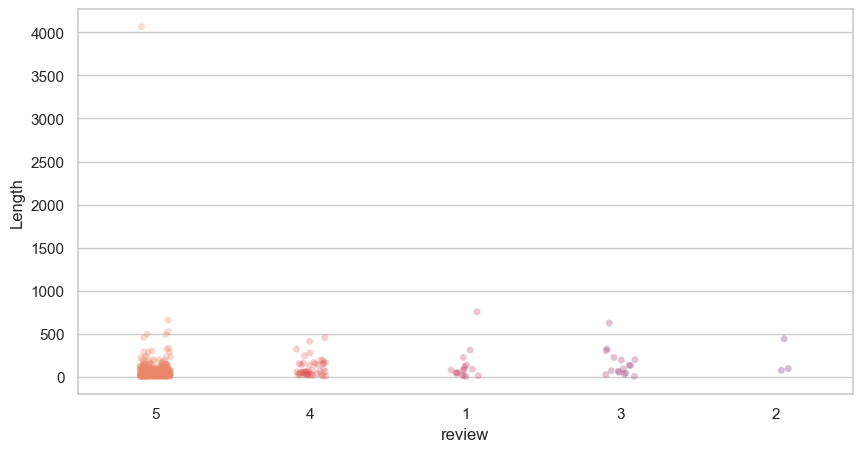

In [9]:
sns.stripplot(data=df_playground_reviews[:369], x='review', y='Length', palette='flare', alpha=0.3)
#обнаружена анамальная длина отзыва

In [25]:
df_playground_reviews['comment'].iloc[54] #при чистке оставлю только русский

'Este parque para niños es increíble, tiene 3 toboganes gigantes, muy altos,  los niños se vuelven locos de alegría. También hay un area de amacas, son muchas pero van muchos niños y adolescentes, detrás estan los baños, gratuitos y limpios. Para no ver a los adolescentes vaya temprano. Detrás está el Luna Park con juegos mecánicos, ₱250 cada uno.\n\nИгровая площадка «Салют» — самый крупный публичный уличный игровой комплекс в России. Проект был создан Парком Горького и реализован Музеем современного искусства «Гараж» к 90-летию Парка.\n\nСалют» состоит из девяти индивидуально спроектированных пространств для игр с песком, водой, цветом, звуком, высотой и глубиной, разными фактурами, формами и размерами. Каждое из этих пространств задействует все органы чувств, помогая в развитии детей, в получении ими аудиального, визуального и тактильного опыта и давая возможность по-новому ощутить собственное тело в пространстве.\n\nНе имеющий аналогов в мире комплекс «Мегакачели» включает в себя 29

### Изменю оценки в данных на более простые для обучения

In [16]:
df = df_playground_reviews.copy()
df

,name,gender,date,review,comment,location,resource
0,Дмитрий,male,2022,5,"Главное, ребёнку нравится. Но летом народу оче...",Парк Горького. Салют,google
1,Михаил Лось,male,2022,5,Здесь очень весело!),Парк Горького. Салют,google
2,Vika Andreeva,female,2021,5,Очень классное место.Очень весело.Особенно пон...,Парк Горького. Салют,google
3,Светлана Рабинович,female,2021,5,"Замечательный комплекс площадок, много качелей...",Парк Горького. Салют,google
4,Денис Пупыкин,male,2021,5,Отличное место для игр с детьми))),Парк Горького. Салют,google
...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,Интересная площадка для детей,Бунинские луга. Пирамиды,yandex
1264,Татьяна Б,female,2020,NaN,Очень хорошая площадка! Нам очень нравится. Го...,Бунинские луга. Пирамиды,yandex
1265,Ольга Кузнецова,female,2020,NaN,Мой ребенок готов сюда эмигрировать.,Бунинские луга. Пирамиды,yandex
1266,Иван,male,2020,NaN,Шикарная площадка с водой. Дети часами могут п...,Бунинские луга. Пирамиды,yandex


In [17]:
def rating(score):
    if score > 3:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

In [18]:
df['review'].iloc[:369] = df['review'].iloc[:369].astype('int')

C:\Users\keybi\AppData\Local\Temp\ipykernel_7552\2773798946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'].iloc[:369] = df['review'].iloc[:369].astype('int')


In [19]:
df['review'].iloc[:369] = df['review'].iloc[:369].apply(rating)

C:\Users\keybi\AppData\Local\Temp\ipykernel_7552\3919030917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'].iloc[:369] = df['review'].iloc[:369].apply(rating)


In [20]:
df['comment'] = df['comment'].str.lower()

### Приведу текст к одной высоте и удалю пунктуацию и цифры

In [21]:
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^а-яА-Я]', ' ', str(inputs))

In [22]:
df['comment'] = df['comment'].apply(remove_punctuations_numbers)

In [23]:
df

,name,gender,date,review,comment,location,resource
0,Дмитрий,male,2022,0,главное реб нку нравится но летом народу оче...,Парк Горького. Салют,google
1,Михаил Лось,male,2022,0,здесь очень весело,Парк Горького. Салют,google
2,Vika Andreeva,female,2021,0,очень классное место очень весело особенно пон...,Парк Горького. Салют,google
3,Светлана Рабинович,female,2021,0,замечательный комплекс площадок много качелей...,Парк Горького. Салют,google
4,Денис Пупыкин,male,2021,0,отличное место для игр с детьми,Парк Горького. Салют,google
...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,интересная площадка для детей,Бунинские луга. Пирамиды,yandex
1264,Татьяна Б,female,2020,NaN,очень хорошая площадка нам очень нравится го...,Бунинские луга. Пирамиды,yandex
1265,Ольга Кузнецова,female,2020,NaN,мой ребенок готов сюда эмигрировать,Бунинские луга. Пирамиды,yandex
1266,Иван,male,2020,NaN,шикарная площадка с водой дети часами могут п...,Бунинские луга. Пирамиды,yandex


### Токенизация с помощью NLTK
Использую токенизацию при обработке естественного языка для разделения абзацев и предложений на более мелкие единицы, которым легче присваивать значения

In [24]:
def tokenization(inputs):  
    return word_tokenize(inputs)

In [25]:
df['text_tokenized'] = df['comment'].apply(tokenization)

In [26]:
df

,name,gender,date,review,comment,location,resource,text_tokenized
0,Дмитрий,male,2022,0,главное реб нку нравится но летом народу оче...,Парк Горького. Салют,google,"[главное, реб, нку, нравится, но, летом, народ..."
1,Михаил Лось,male,2022,0,здесь очень весело,Парк Горького. Салют,google,"[здесь, очень, весело]"
2,Vika Andreeva,female,2021,0,очень классное место очень весело особенно пон...,Парк Горького. Салют,google,"[очень, классное, место, очень, весело, особен..."
3,Светлана Рабинович,female,2021,0,замечательный комплекс площадок много качелей...,Парк Горького. Салют,google,"[замечательный, комплекс, площадок, много, кач..."
4,Денис Пупыкин,male,2021,0,отличное место для игр с детьми,Парк Горького. Салют,google,"[отличное, место, для, игр, с, детьми]"
...,...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,интересная площадка для детей,Бунинские луга. Пирамиды,yandex,"[интересная, площадка, для, детей]"
1264,Татьяна Б,female,2020,NaN,очень хорошая площадка нам очень нравится го...,Бунинские луга. Пирамиды,yandex,"[очень, хорошая, площадка, нам, очень, нравитс..."
1265,Ольга Кузнецова,female,2020,NaN,мой ребенок готов сюда эмигрировать,Бунинские луга. Пирамиды,yandex,"[мой, ребенок, готов, сюда, эмигрировать]"
1266,Иван,male,2020,NaN,шикарная площадка с водой дети часами могут п...,Бунинские луга. Пирамиды,yandex,"[шикарная, площадка, с, водой, дети, часами, м..."


### Удалю стоп-слова
Так как это один из наиболее часто используемых этапов предварительной обработки в различных приложениях NLP. Идея состоит в том, чтобы просто удалить слова, такие как местоимения, предлоги и тд., которые часто встречаются в предложениях, но зачастую не влияют на результат

In [27]:
remove_tr = ['переведено', 'оригинал'] #оставшиеся от инностранного текста

In [28]:
stop_words = set(stopwords.words("russian"))
rem_w = ['нет', 'хорошо', 'больше', 'всего', 'конечно', 'лучше', 'много', 'нельзя', 'никогда', 'после', \
        'было', 'только']
for i in rem_w:
    stop_words.remove(i)

def stopwords_remove(inputs): 
    return [k for k in inputs if k not in stop_words and k not in remove_tr ]

In [29]:
df['text_stop'] = df['text_tokenized'].apply(stopwords_remove)

In [30]:
df

,name,gender,date,review,comment,location,resource,text_tokenized,text_stop
0,Дмитрий,male,2022,0,главное реб нку нравится но летом народу оче...,Парк Горького. Салют,google,"[главное, реб, нку, нравится, но, летом, народ...","[главное, реб, нку, нравится, летом, народу, о..."
1,Михаил Лось,male,2022,0,здесь очень весело,Парк Горького. Салют,google,"[здесь, очень, весело]","[очень, весело]"
2,Vika Andreeva,female,2021,0,очень классное место очень весело особенно пон...,Парк Горького. Салют,google,"[очень, классное, место, очень, весело, особен...","[очень, классное, место, очень, весело, особен..."
3,Светлана Рабинович,female,2021,0,замечательный комплекс площадок много качелей...,Парк Горького. Салют,google,"[замечательный, комплекс, площадок, много, кач...","[замечательный, комплекс, площадок, много, кач..."
4,Денис Пупыкин,male,2021,0,отличное место для игр с детьми,Парк Горького. Салют,google,"[отличное, место, для, игр, с, детьми]","[отличное, место, игр, детьми]"
...,...,...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,интересная площадка для детей,Бунинские луга. Пирамиды,yandex,"[интересная, площадка, для, детей]","[интересная, площадка, детей]"
1264,Татьяна Б,female,2020,NaN,очень хорошая площадка нам очень нравится го...,Бунинские луга. Пирамиды,yandex,"[очень, хорошая, площадка, нам, очень, нравитс...","[очень, хорошая, площадка, нам, очень, нравитс..."
1265,Ольга Кузнецова,female,2020,NaN,мой ребенок готов сюда эмигрировать,Бунинские луга. Пирамиды,yandex,"[мой, ребенок, готов, сюда, эмигрировать]","[ребенок, готов, сюда, эмигрировать]"
1266,Иван,male,2020,NaN,шикарная площадка с водой дети часами могут п...,Бунинские луга. Пирамиды,yandex,"[шикарная, площадка, с, водой, дети, часами, м...","[шикарная, площадка, водой, дети, часами, могу..."


### Лемматизация
Лемматизация отвечает за группировку разных форм слов в базовую форму слова, имеющую одинаковое значение. Применяется для уменьшения размерности вариаций слов, что в дальнейшем пригодиться в обучении

In [31]:
def morth_lem(a):
    return [ morph.parse(m)[0].normal_form for m in a]

In [32]:
df['lemmatized'] = df['text_stop'].apply(morth_lem)

In [33]:
df['lemmatized'] = df['lemmatized'].str.join(' ')

In [46]:
mostUsedWords = df['lemmatized'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='Most 200 Used Words the Dataset (preprocesing)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
pio.renderers.default = 'iframe'
fig.show()

### Удалю часто встречающиеся слова и меньше 3 букв, которые не несут смысловую нагрузку 

In [29]:
remove_m_w = ['площадка', 'ребёнок', 'ребёночек']

In [ ]:
def remove_less_than_3(inputs): 
    return [j for j in inputs if (len(j) > 3 and j != 'нет') and j not in remove_m_w]


df['lemmatized'] = df['lemmatized'].apply(remove_less_than_3)

<a id='3.2'></a>

## 3.2 Предобработка отзывов на парки для обучения сети 


In [35]:
data_m = pd.read_csv('clean_prepr_google_review_parks.csv')
# датасет из 22 тысяч отзывов и оценок на парки, ранее предобработала и лемматизировала
data_m

,rating,review,lemmatized
0,0,Абсолютно волшебное место. Прогулка по этому и...,"['абсолютно', 'волшебный', 'место', 'прогулка'..."
1,0,Абсолютно культовое место для Москвы.\nОтлична...,"['абсолютно', 'культовый', 'место', 'москва', ..."
2,2,Абсолютно все лестницы не оборудованы пандусам...,"['абсолютно', 'лестница', 'оборудовать', 'панд..."
3,0,Моё абсолютно любимое место для бега и воркаут...,"['абсолютно', 'любимый', 'место', 'бег', 'ворк..."
4,1,Абсолютно не понравилось. Если бы не павильон ...,"['абсолютно', 'понравиться', 'если', 'павильон..."
...,...,...,...
22237,0,"1января 2022 года: работает бесплатный каток, ...","['январь', 'год', 'работать', 'бесплатный', 'к..."
22238,0,Январь 2018. Каток по всему парку - очень инте...,"['январь', 'каток', 'весь', 'парка', 'очень', ..."
22239,2,"1 января 2021: очень плохо посыпаны дорожки, о...","['январь', 'очень', 'плохо', 'посыпать', 'доро..."
22240,0,"Яркий, красочный праздник.. душевная атмосфера","['яркий', 'красочный', 'праздник', 'душевный',..."


In [36]:
data_m['lemmatized'] = data_m['lemmatized'].apply(remove_punctuations_numbers)

### узнаю какие слова преобладают в датасете

In [37]:
mostUsedWords = data_m['lemmatized'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='Most 200 Used Words the Dataset (preprocesing)',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

### Тут также удалю часто встречающиеся слова и меньше3 , которые не несут смысловую нагрузку 

In [100]:
data2 = data_m.copy()

In [101]:
data2['lemmatized'] = data2['lemmatized'].str.split()


In [89]:
remove_m_word = ['площадка', 'парк', 'место', 'ребёнок', 'парка', 'детский', 'есть', 'весь', 'москва']

In [102]:
def remove_less_than_3_2(inputs): 
    return [j for j in inputs if (len(j) > 3 and j != 'нет') and j not in remove_m_word]


data2['lemmatized'] = data2['lemmatized'].apply(remove_less_than_3_2)

### Проверю на сбалансиртванность классов

In [104]:
data3 = data2.copy()


<AxesSubplot:xlabel='count', ylabel='rating'>

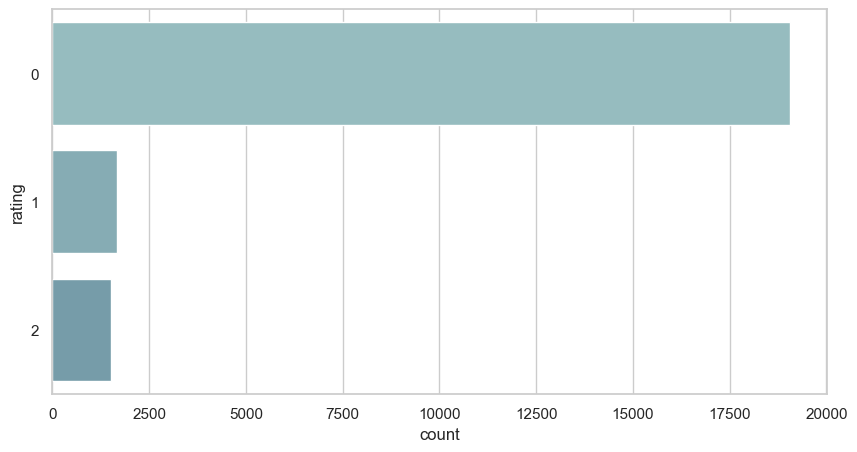

In [54]:
sns.countplot(y = data3.rating, palette=pal ) 

#### несбалансированные данные негативно сказываются на обучении, сети легче примкнуть к большему классу, что влечет хорошую точность по показателям, но на деле сеть будет везде ставить одно значение, что будет неправильным

### Приведу к балансу с помощью рандомного выбора, выровняю по меньшему классу - негативному

Выбрала undersampling, тк другие способы мне показались в данном случае не уместными.
У всех есть свои минусы и плюсы, но например увеличение меньших классов(oversampling), повлечет множество одинаковых значений, и некоторые одинаковые могут уйти в тестовую и обучающие выборки, что может переобучить сеть
Кроме того количества меньших классов считаю достаточным для выравнивания по нему

In [105]:
count_class_0, count_class_1, count_class_2 = data3.rating.value_counts()

# Divide by class
df_class_0 = data3[data3['rating'] == 0]
df_class_1 = data3[data3['rating'] == 1]
df_class_2 = data3[data3['rating'] == 2]

Random under-sampling:
0    1510
1    1510
2    1510
Name: rating, dtype: int64


<AxesSubplot:xlabel='count', ylabel='rating'>

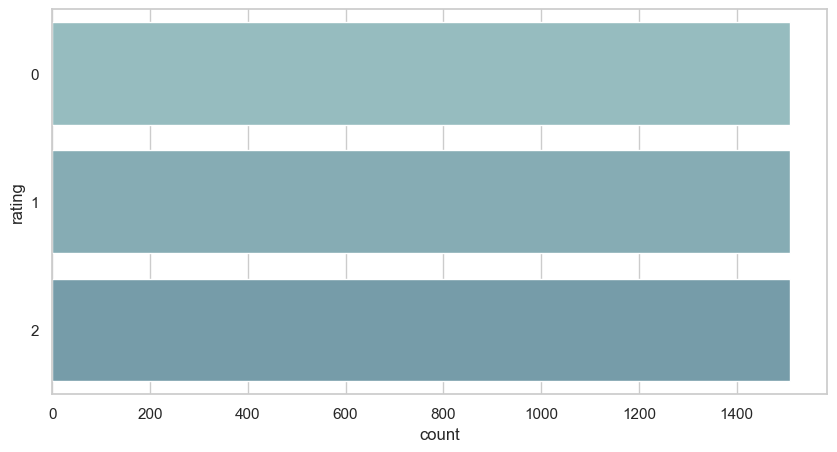

In [106]:
df_class_0_under = df_class_0.sample(count_class_2)
df_class_1_under = df_class_1.sample(count_class_2)
df_test_under = pd.concat([df_class_0_under, df_class_1_under ,df_class_2], axis=0)

print('Random under-sampling:')
print(df_test_under.rating.value_counts())

sns.countplot(y = df_test_under.rating, palette=pal )

In [107]:
data4 = df_test_under.copy()

In [108]:
data4

,rating,review,lemmatized
21893,0,Шикарный парк много места и детям и взрослым.,"[шикарный, много, взрослый]"
11932,0,Очень нравится гулять в этом парке с друзьями ...,"[очень, нравиться, гулять, друг, семья, красив..."
18458,0,Тихо спокойно красиво,"[тихо, спокойно, красиво]"
10050,0,Отличный парк с множеством развлечений для дет...,"[отличный, множество, развлечение, взрослый, к..."
15985,0,Приличный и хорошо обустроенный парк. Отличное...,"[приличный, хорошо, обустроить, отличный, отдо..."
...,...,...,...
22214,2,Этот парк очень красивый,"[этот, очень, красивый]"
22216,2,"Этот парк очень не ухожен и грязен, проходит р...","[этот, очень, уходить, грязный, проходить, рен..."
22236,2,Язык не повернется назвать это парком.,"[язык, повернуться, назвать]"
22239,2,"1 января 2021: очень плохо посыпаны дорожки, о...","[январь, очень, плохо, посыпать, дорожка, очен..."


In [109]:
data4 = data4.reset_index(drop=True)
data4

,rating,review,lemmatized
0,0,Шикарный парк много места и детям и взрослым.,"[шикарный, много, взрослый]"
1,0,Очень нравится гулять в этом парке с друзьями ...,"[очень, нравиться, гулять, друг, семья, красив..."
2,0,Тихо спокойно красиво,"[тихо, спокойно, красиво]"
3,0,Отличный парк с множеством развлечений для дет...,"[отличный, множество, развлечение, взрослый, к..."
4,0,Приличный и хорошо обустроенный парк. Отличное...,"[приличный, хорошо, обустроить, отличный, отдо..."
...,...,...,...
4525,2,Этот парк очень красивый,"[этот, очень, красивый]"
4526,2,"Этот парк очень не ухожен и грязен, проходит р...","[этот, очень, уходить, грязный, проходить, рен..."
4527,2,Язык не повернется назвать это парком.,"[язык, повернуться, назвать]"
4528,2,"1 января 2021: очень плохо посыпаны дорожки, о...","[январь, очень, плохо, посыпать, дорожка, очен..."


In [110]:
data4['rating'] = data4['rating'].astype('int')

In [111]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4530 entries, 0 to 4529
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      4530 non-null   int32 
 1   review      4530 non-null   object
 2   lemmatized  4530 non-null   object
dtypes: int32(1), object(2)
memory usage: 88.6+ KB


In [112]:
# Длина отзывов
data4['Length'] = data4['lemmatized'].apply(len)
data4[['lemmatized','Length']].head()

,lemmatized,Length
0,"[шикарный, много, взрослый]",3
1,"[очень, нравиться, гулять, друг, семья, красив...",24
2,"[тихо, спокойно, красиво]",3
3,"[отличный, множество, развлечение, взрослый, к...",7
4,"[приличный, хорошо, обустроить, отличный, отдо...",8


<AxesSubplot:xlabel='rating', ylabel='Length'>

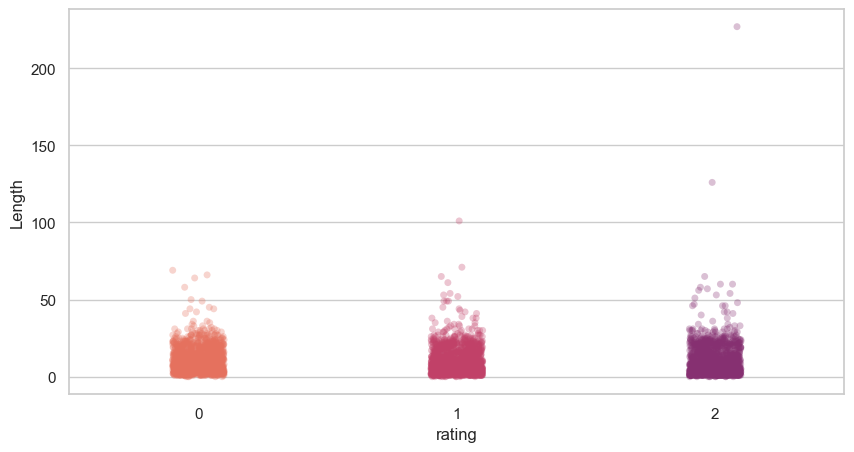

In [113]:
sns.stripplot(data=data4, x='rating', y='Length', palette='flare', alpha=0.3)

In [109]:
#data4.to_csv('parks_dp', index=False)

In [5]:
data4 = pd.read_csv('parks_dp')

<a id='3.3'></a>

## 3.3 Обучение

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data4['lemmatized'], data4['rating'], test_size=0.20, random_state=42)

In [72]:
X_train.count()

3918

<a id='Sk'></a>

## Сначала выясню удасться ли предсказать с помощья Sklearn

CountVectorizer -считает встречаемость слов в документе.
TfidfVectorizer() - учитывает важность слова по отношению встречаемости слов к общему числу слов в документе
Word2Vec -вычисляет распределенное векторное представление слов. Основное преимущество распределенных представлений заключается в том, что похожие слова имеют схожие векторные представления.

In [7]:
tfid = TfidfVectorizer(lowercase = False)
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [8]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [9]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [10]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

C:\Users\keybi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\keybi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [72]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.496302
1,RandomForestClassifier,0.585601
2,SVC,0.632049
3,LogisticRegression,0.629752
4,KNeighborsClassifier,0.511349
5,BernoulliNB,0.618269


In [11]:
log = LogisticRegression()
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [12]:
# Logistic Regression
def ml_predict(text):
    clean_text = remove_punctuations_numbers(text)
    #stop_w = stopwords_remove(clean_text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [31]:
df2 = df.copy()

## 

In [33]:
df2['predict1']= df2['comment'].apply(ml_predict)
df2[['review','predict1' ]].head(10) 

,review,predict1
0,0,0
1,0,2
2,0,0
3,0,0
4,0,2
5,0,2
6,0,2
7,0,1
8,0,2
9,0,2


### Малая точность

<a id='Tf'></a>

### Обучение с помощью TENSORFLOW

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data4['lemmatized'], data4['rating'], test_size=0.20 )

In [50]:
num_words = 6349
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')

In [51]:
tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen= 400)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen= 400)

#One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 6349


In [136]:
train_padded

array([[   0,    0,    0, ...,  184,   66,   67],
       [   0,    0,    0, ...,  685,  223,    2],
       [   0,    0,    0, ...,  224, 1252,   30],
       ...,
       [   0,    0,    0, ..., 1799,  469, 1785],
       [   0,    0,    0, ..., 7073,  103,   14],
       [   0,    0,    0, ...,    1,  167,  308]])

In [173]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [177]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 128),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(64, kernel_regularizer=l2(0.001),# регуляризация весов в модели
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(32, kernel_regularizer=l2(0.001), # регуляризация весов в модели
                                                          bias_regularizer=l2(0.001), activation='relu'), 
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1017728   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                      

In [178]:
model_save_path = '2023.02.05_s_best_model_15_30_2.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)


In [179]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=15, validation_split=0.2, batch_size =30, callbacks=[checkpoint_callback] )

Epoch 1/15
105/105 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.3305
Epoch 1: val_accuracy improved from -inf to 0.33418, saving model to 2023.02.05_s_best_model_15_30_2.h5
105/105 [==============================] - 63s 531ms/step - loss: 1.2228 - accuracy: 0.3305 - val_loss: 1.2172 - val_accuracy: 0.3342
Epoch 2/15
105/105 [==============================] - ETA: 0s - loss: 1.2118 - accuracy: 0.3592
Epoch 2: val_accuracy did not improve from 0.33418
105/105 [==============================] - 54s 512ms/step - loss: 1.2118 - accuracy: 0.3592 - val_loss: 1.2083 - val_accuracy: 0.3342
Epoch 3/15
105/105 [==============================] - ETA: 0s - loss: 1.2021 - accuracy: 0.3633
Epoch 3: val_accuracy did not improve from 0.33418
105/105 [==============================] - 53s 508ms/step - loss: 1.2021 - accuracy: 0.3633 - val_loss: 1.1999 - val_accuracy: 0.3342
Epoch 4/15
105/105 [==============================] - ETA: 0s - loss: 1.1928 - accuracy: 0.3774
Epoch 4:

LSTM
'2023.02.04_s_best_model_15_30_1.h5'
до 11 эпохи v_s = T_T dr.outs = 0.5 128,128, 32, 8, 15 эпох, batch_size = 20
loss: 0.9327 - accuracy: 0.5609 - val_loss: 0.9250 - val_accuracy: 0.6000
'2023.02.04_s_best_model_15_30_2.h5'
до 12 эпохи v_s = 0.2 dr.outs = 0.5 254,128, 32, 8, 15 эпох, batch_size = 30
loss: 0.8616 - accuracy: 0.6313 - val_loss: 0.9239 - val_accuracy: 0.5957
'2023.02.04_s_best_model_15_30_3.h5'
v_s = 0.2 dr.outs = 0.5 128,64, 32, 8, 15 эпох, batch_size = 50   
loss: 0.9587 - accuracy: 0.5298 - val_loss: 0.9415 - val_accuracy: 0.5829
'2023.02.04_s_best_model_15_30_4.h5'
до 12 эпохи v_s = 0.2 dr.outs = 0.5 128,64, 32, 8, 15 эпох, batch_size = 30
loss: 0.9874 - accuracy: 0.5461 - val_loss: 0.9974 - val_accuracy: 0.5714
'2023.02.05_s_best_model_15_30_1.h5'
v_s = 0.2 dr.outs = 0.5 128,128, 64,32, 15 эпох, batch_size = 30
loss: 0.8531 - accuracy: 0.6290 - val_loss: 0.9162 - val_accuracy: 0.5702
'2023.02.05_s_best_model_15_30_2.h5'
v_s = 0.2 dr.outs = 0.5 128,64, 64,32, 15 эпох, batch_size = 30
oss: 0.8700 - accuracy: 0.6191 - val_loss: 0.8935 - val_accuracy: 0.6084

LSTM
'2023.02.03_s_best_model_15_30.h5'
до 13 эпохи v_s = 0.2 dr.outs = 0.5 254,128, 64, 32, 15 эпох, batch_size = 100
loss: 0.8391 - accuracy: 0.6175 - val_loss: 0.9957 - val_accuracy: 0.5904
'2023.02.03_s_best_model_15_30_2.h5'
до 13 эпохи v_s = T_T dr.outs = 0.5 254,128, 64, 32, 15 эпох, batch_size = 30
loss: 0.6544 - accuracy: 0.7693 - val_loss: 0.9794 - val_accuracy: 0.6159
'2023.02.03_s_best_model_15_30_3.h5'
до 13 эпохи v_s = T_T dr.outs = 0.5 128,128, 64, 32, 15 эпох, batch_size = 30
loss: 0.7538 - accuracy: 0.6777 - val_loss: 0.9789 - val_accuracy: 0.5993
'2023.02.03_s_best_model_15_30_4.h5'
до 13 эпохи v_s = T_T dr.outs = 0.5 128,128, 64, 16, 15 эпох, batch_size = 30
loss: 0.9638 - accuracy: 0.5425 - val_loss: 0.9746 - val_accuracy: 0.5254
'2023.02.03_s_best_model_15_30_5.h5'
до 12 эпохи v_s = T_T dr.outs = 0.25 128,128, 128, 64, 15 эпох, batch_size = 30
loss: 0.7246 - accuracy: 0.7094 - val_loss: 1.0059 - val_accuracy: 0.5949
'2023.02.03_s_best_model_15_30_6.h5'
до 12 эпохи v_s = T_T dr.outs = 0.25 128,128, 128, 64, 15 эпох, batch_size = 10
loss: 0.2911 - accuracy: 0.9272 - val_loss: 1.9529 - val_accuracy: 0.6004
'2023.02.03_s_best_model_15_30_7.h5'
до 7 эпохи v_s = T_T dr.outs = 0.5 128,128, 128, 64, 15 эпох, batch_size = 20

LSTM
'2023.02.02_best_model_15_30_4.h5'
до 12 эпохи v_s = tt dr.outs = 0.5 128,128, 32, 32, 15 эпох, batch_size = 30 loss: 0.7901 - accuracy: 0.6175 - val_loss: 0.9952 - val_accuracy: 0.6113
'2023.02.02_best_model_15_30_5.h5'
до 15 эпохи v_s = t,t dr.outs = 0.5 128,128, 64, 32, 15 эпох, batch_size = 30 loss: 0.7016 - accuracy: 0.7232 - val_loss: 1.0284 - val_accuracy: 0.6236
'2023.02.02_best_model_15_30_6.h5'
до 15 эпохи v_s = t,t dr.outs = 0.5 64,64, 32, 16, 15 эпох, batch_size = 30 loss: 0.7817 - accuracy: 0.6264 - val_loss: 0.9442 - val_accuracy: 0.6125
'2023.02.02_best_model_15_30_7.h5'
до 11 эпохи dr.outs = 0.5 254,128, 64, 16, 15 эпох, batch_size = 30 loss: 0.8105 - accuracy: 0.6577 - val_loss: 0.9358 - val_accuracy: 0.6248
'2023.02.02_best_model_15_30_8.h5'
до 15 эпохи dr.outs = 0.5 128,64, 16, 16, 15 эпох, batch_size = 30
loss: 0.9052 - accuracy: 0.5575 - val_loss: 0.8763 - val_accuracy: 0.6052
'2023.02.02_best_model_15_30_10.h5'
до 14 эпохи dr.outs = 0.5 254,128, 64, 16, 15 эпох, batch_size = 50 loss: 0.8841 - accuracy: 0.6052 - val_loss: 0.9129 - val_accuracy: 0.5793
'2023.02.02_best_model_15_30_11.h5'
до 11 эпохи dr.outs = 0.5 128,64, 16, 16, 15 эпох, batch_size = 30 loss: 0.8807 - accuracy: 0.5716 - val_loss: 0.9107 - val_accuracy: 0.5892
'2023.02.02_best_model_15_30_12.h5'
вся длина до 8 эпохи dr.outs = 0.5 128,128, 64, 32, 25 эпох, batch_size = 30 loss: 0.9091 - accuracy: 0.6025 - val_loss: 0.9093 - val_accuracy: 0.6136
200 dr.outs = 0.5 128,128, 64, 32, 25 эпох, batch_size = 30 loss: 0.6300 - accuracy: 0.6969 - val_loss: 1.0507 - val_accuracy: 0.6008
300 dr.outs = 0.5 128,128, 64, 32, 25 эпох, batch_size = 30 loss: 0.8230 - accuracy: 0.6276 - val_loss: 0.9157 - val_accuracy: 0.6047
'2023.02.02_best_model_15_30_3.h5' 
до 3 эпохи dr.outs = 0.5 128,64, 16, 16, 15 эпох, batch_size = 30 loss: 0.4616 - accuracy: 0.8269 - val_loss: 0.4813 - val_accuracy: 0.7749
'2023.02.02_best_model_15_30_13.h5'
до 1 эпохи v_s = 0.2 dr.outs = 0.5 128,128, 64, 32, 25 эпох, batch_size = 30 val_accuracy: 0.900 
'2023.02.02_best_model_15_30_13.h5'
до 1 эпохи v_s = 0.5 dr.outs = 0.5 128,128, 64, 32, 25 эпох, batch_size = 30 loss: 0.1836 - accuracy: 0.9508 - val_loss: 0.6320 - val_accuracy: 0.8253
loss: 0.1499 - accuracy: 0.9613 - val_loss: 1.0026 - val_accuracy: 0.7811
'2023.02.02_best_model_15_30_15.h5'
до 15 эпохи v_s = 0.2 dr.outs = 0.5 254,128, 64, 32, 25 эпох, batch_size = 100
loss: 0.8391 - accuracy: 0.6175 - val_loss: 0.9957 - val_accuracy: 0.5904

<AxesSubplot:>

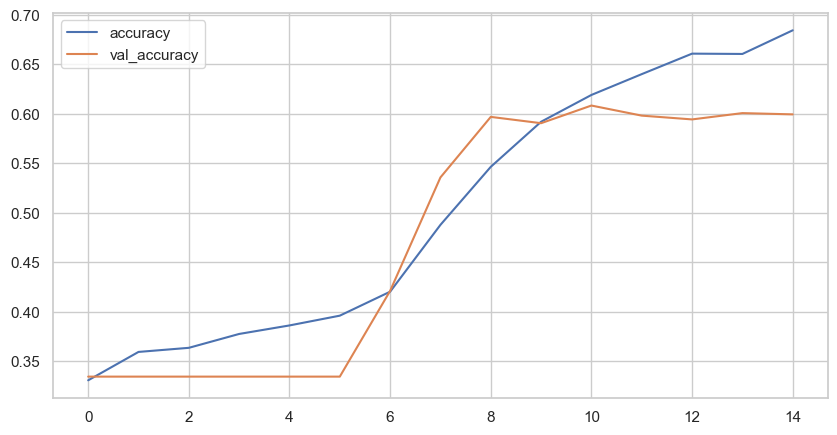

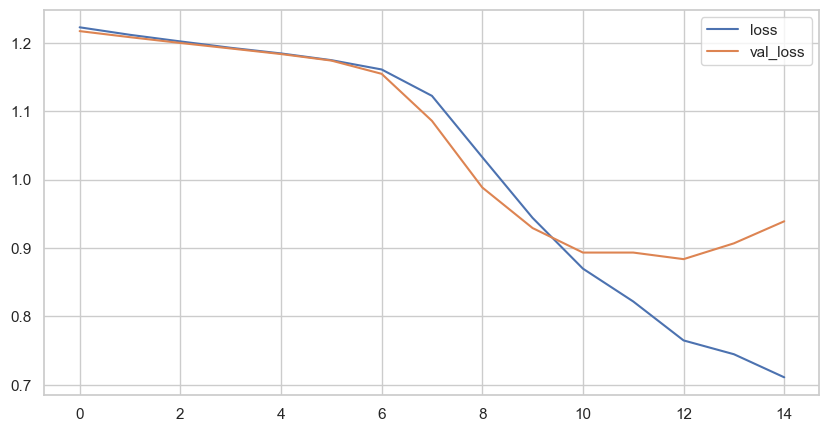

In [180]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [213]:
model2 = Sequential()
model2.add(Embedding(total_word, 254))
model2.add(LSTM(128, return_sequences=True))
#model2.add(Dense(64, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='relu'))
#model2.add(Dropout(0.5))
model2.add(LSTM(64))
model2.add(Dense(3, activation='softmax'))
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 254)         2019554   
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         196096    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_38 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2,265,253
Trainable params: 2,265,253
Non-trainable params: 0
_________________________________________________________________


In [214]:
model_save_path2 = '2023.02.05_best_model2_15_30.h5'
checkpoint_callback2 = ModelCheckpoint(model_save_path2, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)


In [215]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

model2.fit(train_padded, train_labels, batch_size=30, epochs=15, validation_split = 0.2, callbacks=[checkpoint_callback2])

Epoch 1/15
105/105 [==============================] - ETA: 0s - loss: 1.0933 - accuracy: 0.3825
Epoch 1: val_accuracy improved from -inf to 0.33418, saving model to 2023.02.05_best_model2_15_30.h5
105/105 [==============================] - 76s 668ms/step - loss: 1.0933 - accuracy: 0.3825 - val_loss: 1.0914 - val_accuracy: 0.3342
Epoch 2/15
105/105 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.4140
Epoch 2: val_accuracy improved from 0.33418 to 0.36224, saving model to 2023.02.05_best_model2_15_30.h5
105/105 [==============================] - 68s 645ms/step - loss: 1.0577 - accuracy: 0.4140 - val_loss: 1.0312 - val_accuracy: 0.3622
Epoch 3/15
105/105 [==============================] - ETA: 0s - loss: 0.9059 - accuracy: 0.5518
Epoch 3: val_accuracy improved from 0.36224 to 0.58291, saving model to 2023.02.05_best_model2_15_30.h5
105/105 [==============================] - 68s 651ms/step - loss: 0.9059 - accuracy: 0.5518 - val_loss: 0.9084 - val_accuracy: 0.5829
E

<AxesSubplot:>

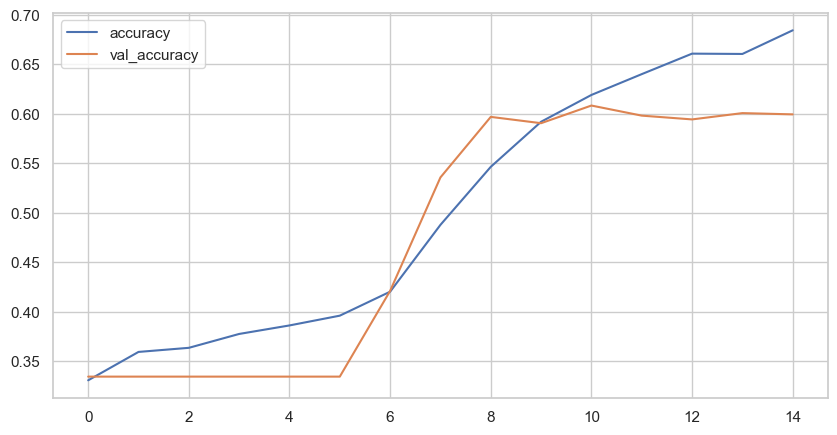

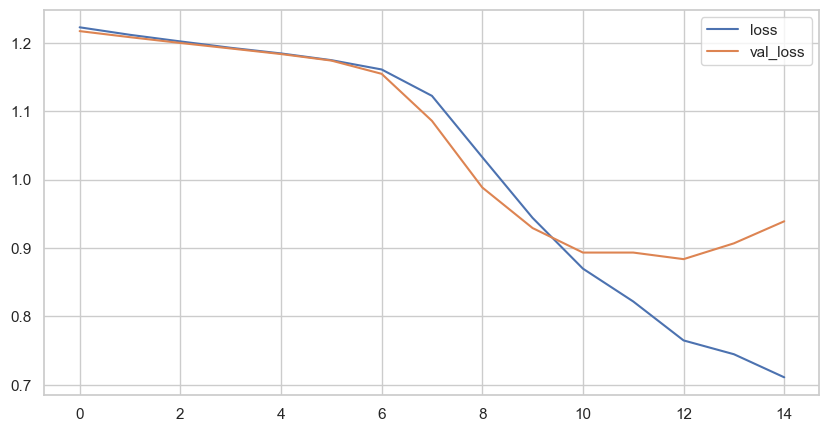

In [216]:
metrics2 = pd.DataFrame(model2.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [35]:
model = tf.keras.models.load_model('2023.02.05_s_best_model_15_30_2.h5')

In [36]:
model2 = tf.keras.models.load_model('2023.02.05_best_model2_15_30.h5')

In [219]:
pred1 = model.predict(test_padded)
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred1, axis=-1)

31/31 [==============================] - 5s 117ms/step


In [220]:
pred2 = model2.predict(test_padded)
true_labels2 = np.argmax(test_labels, axis=-1)
pred_labels2 = np.argmax(pred2, axis=-1)

31/31 [==============================] - 7s 169ms/step


In [223]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[320  49  28]
 [ 73 100 140]
 [ 32  67 171]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       397
           1       0.46      0.32      0.38       313
           2       0.50      0.63      0.56       270

    accuracy                           0.60       980
   macro avg       0.57      0.59      0.57       980
weighted avg       0.59      0.60      0.59       980



In [224]:
print(confusion_matrix(true_labels2, pred_labels2))
print(classification_report(true_labels2, pred_labels2))

[[291  76  30]
 [ 57 144 112]
 [ 33  76 161]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       397
           1       0.49      0.46      0.47       313
           2       0.53      0.60      0.56       270

    accuracy                           0.61       980
   macro avg       0.59      0.60      0.59       980
weighted avg       0.61      0.61      0.61       980



precision - отношение TP(true positive) к сумме TP + FP(false positive) - Это доля объектов, названными классификатором положительными и при этом действительно являющимися положительными
recall - отношение TP к TP + FN - Это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм 
f1 - среднее гармоническое precision и recall

### Низкая точность на тестовой выборке, из-за близости позитивных с нейтральными и негативных с нейтральными

### Проверка педсказаний 

In [66]:
# Deep Neural Network
def dl_predict(text):
    clean_text = remove_punctuations_numbers(text).lower()
    token = tokenization(clean_text)
    stop_w = stopwords_remove(token)
    if len(stop_w) >= 1 :
        lemma = morth_lem(stop_w)
        seq = tokenizer.texts_to_sequences([lemma])
        padded = pad_sequences(seq)

        pred = model2.predict(padded)
        # Get the label name back
        result = lb.inverse_transform(pred)[0]
    
        return result
    else:
        return 'Nan'

In [61]:
df['comment'].iloc[27]

'к сожалению, в такую прекрасную и жаркую погоду самая интересная часть комплекса (зона с водными развлечениями) не работала - не было воды. очень многие приезжали с детьми только ради этой зоны...'

In [248]:
text = 'мой ребенок обожает эту площадку'

#print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 27ms/step
Prediction using DNN: 0


In [62]:
text = 'к сожалению, в такую прекрасную и жаркую погоду самая интересная часть комплекса не работала'

#print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 32ms/step
Prediction using DNN: 2


In [243]:
text = 'Ужасное место, падаешь и падаешь, на качелях бьют'

#print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 28ms/step
Prediction using DNN: 2


In [63]:
df3 = df2.copy()

In [65]:
df3

,name,gender,date,review,comment,location,resource,Length,predict1
0,Дмитрий,male,2022,0,"главное, ребёнку нравится. но летом народу оче...",Парк Горького. Салют,google,55,0
1,Михаил Лось,male,2022,0,здесь очень весело!),Парк Горького. Салют,google,20,2
2,Vika Andreeva,female,2021,0,очень классное место.очень весело.особенно пон...,Парк Горького. Салют,google,69,0
3,Светлана Рабинович,female,2021,0,"замечательный комплекс площадок, много качелей...",Парк Горького. Салют,google,121,0
4,Денис Пупыкин,male,2021,0,отличное место для игр с детьми))),Парк Горького. Салют,google,34,2
...,...,...,...,...,...,...,...,...,...
1263,Рафаэль Т.,male,2020,NaN,интересная площадка для детей,Бунинские луга. Пирамиды,yandex,29,2
1264,Татьяна Б,female,2020,NaN,очень хорошая площадка! нам очень нравится. го...,Бунинские луга. Пирамиды,yandex,143,2
1265,Ольга Кузнецова,female,2020,NaN,мой ребенок готов сюда эмигрировать.,Бунинские луга. Пирамиды,yandex,36,2
1266,Иван,male,2020,NaN,шикарная площадка с водой. дети часами могут п...,Бунинские луга. Пирамиды,yandex,118,2


In [ ]:
df3['predict2']= df3['comment'].apply(dl_predict) #model


In [ ]:
df3['predict3']= df3['comment'].apply(dl_predict) #model2


In [250]:
df3.to_csv('2023.02.05_predicted_data_reviews_dp.csv', index=False)

#### Прокрутка предсказаний
[Итог](#Обученная-сеть-хорошо-наложилась-на-датасет-с-детскими-площадками)

In [251]:
df3[['review', 'predict1', 'predict2', 'predict3']] #predict3 точнее всего

,review,predict1,predict2,predict3
0,0,0,0,0
1,0,1,0,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0
5,0,1,0,0
6,0,0,0,0
7,0,1,0,0
8,0,0,0,0
9,0,1,0,0


### Обученная сеть хорошо наложилась на датасет с детскими площадками

In [ ]:
df3['predict3'].iloc[:369] = df3['review'].iloc[:369] #заменю на уже имеющиеся

In [254]:
df3['predict3'].value_counts(sort=True)

0      1139
2        66
1        59
Nan       4
Name: predict3, dtype: int64

In [255]:
df3[['comment','predict3' ]]

,comment,predict3
0,главное реб нку нравится но летом народу оче...,0
1,здесь очень весело,0
2,очень классное место очень весело особенно пон...,0
3,замечательный комплекс площадок много качелей...,0
4,отличное место для игр с детьми,0
5,отличная плошядка для прогулок с детьми,0
6,площадка просто бомба но желающих одновременн...,0
7,классная детская площадка единственный минус э...,0
8,очень вес лое место,0
9,внук и бабушка были в восторге прекрасное мес...,0


In [258]:
df4 = df3.copy()
df4 = df3[['name','gender', 'comment', 'predict3', 'date', 'location', 'resource', 'lemmatized']].rename(columns = {'predict3': 'rating'})

In [260]:
df4.to_csv('2023.02.05_predicted_data_reviews_dp_f.csv', index=False)